In [4]:
%pip install -i https://pypi.gurobi.com gurobipy

Looking in indexes: https://pypi.gurobi.com
     |████████████████████████████████| 11.5 MB 4.7 MB/s 


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy.sparse as sp
import gurobipy as gp
from gurobipy import *
from scipy.interpolate import CubicSpline
from scipy import stats
from datetime import datetime
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import json
import time
import os
import random

In [6]:
df = pd.read_csv("^STOXX50E.csv")

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-12-31,900.820007,900.820007,900.820007,900.820007,900.820007,0.0
1,1987-01-01,900.820007,900.820007,900.820007,900.820007,900.820007,0.0
2,1987-01-02,891.780029,891.780029,891.780029,891.780029,891.780029,0.0
3,1987-01-05,898.330017,898.330017,898.330017,898.330017,898.330017,0.0
4,1987-01-06,902.320007,902.320007,902.320007,902.320007,902.320007,0.0


In [8]:
stoxx = df.Close
stoxx_dates = df.Date

In [9]:
stoxx = stoxx.dropna()
stoxx_dates = stoxx_dates.dropna()

In [10]:
stoxx_dates = stoxx_dates[2087:len(stoxx)-78].values
stoxx = stoxx[2087:len(stoxx)-78].values

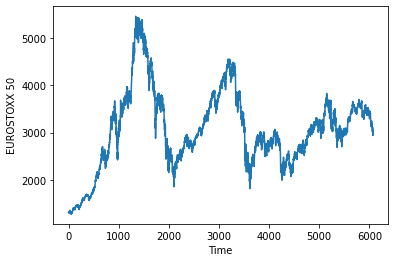

In [11]:
plt.plot(stoxx)
plt.xlabel('Time')
plt.ylabel('EUROSTOXX 50')
plt.show()

Text(0.5, 0, 'Return after 21 days')

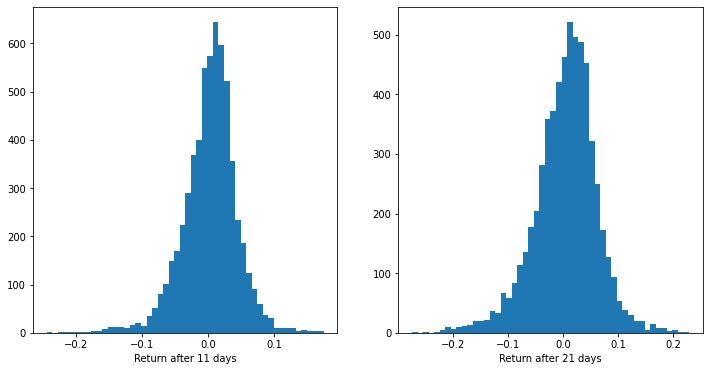

In [12]:
triple = np.zeros((3,len(stoxx)-21))
for i in range(len(stoxx)-21):
    triple[0,i] = 1
    triple[1,i] = (stoxx[i+11]-stoxx[i])/stoxx[i]
    triple[2,i] = (stoxx[i+21]-stoxx[i])/stoxx[i]

plt.figure(figsize = (12,6))    
plt.subplot(1,2,1)
plt.hist(triple[1], bins=50)
plt.xlabel('Return after 11 days')
plt.subplot(1,2,2)
plt.hist(triple[2], bins=50)
plt.xlabel('Return after 21 days')

In [13]:
def bandwith_nrd(vector):
    r = np.quantile(vector, 0.25), np.quantile(vector, 0.75)
    h = (r[1] - r[0])/1.34
    return 4 * 1.06 * min(np.sqrt(np.var(vector,axis=0,ddof=1)), h) * np.power(len(vector),-0.2)

In [14]:
def kde2d_R(x, y, h = None, n=25, lim = None):
    nx = len(x)
    if lim is None:
        lim = (x.min(),x.max(),y.min(),y.max())
    gx = np.linspace(lim[0], lim[1], n)
    gy = np.linspace(lim[2], lim[3], n)
    if h is None:
        h = np.array([bandwith_nrd(x), bandwith_nrd(y)])
    elif len(h)==1:
        h = np.array([h[0],h[0]])
    elif len(h)==2:
        h = np.array(h)
    else:
        print('Bandwidth Vector Length Error')
        return
    if any(h<=0):
        print("Bandwidths Must Be Strictly Positive")
    h = h/4
    ax = (gx.reshape(len(gx),1)-x.reshape(1,len(x)))/h[0]
    ay = (gy.reshape(len(gy),1)-y.reshape(1,len(y)))/h[1]
    z = (stats.norm.pdf(ax).reshape(-1,nx))@((stats.norm.pdf(ay).reshape(-1,nx)).T)
    z = z/(nx*h[0]*h[1])
    return gx,gy,z

In [15]:
def kernel_estimation(last_days=60,today=60,nn=25, h_factor=1):
    x = triple[1,(today-last_days-21):(today-21)]
    y = triple[2,(today-last_days-21):(today-21)]
    h = np.array([bandwith_nrd(x), bandwith_nrd(y)])
    k = kde2d_R(x,y,h = h_factor*h, n=nn, 
             lim = (triple[1].min(), triple[1].max(), triple[2].min(), triple[2].max()))
    return k

In [16]:
def super_rep_robust(x,y,prob_set,func=lambda x,y: abs(x-y),stat_arb=True, lower=False,S_0=1,limit=float('Inf')):

    n1 = len(x[0])
    n2 = len(y[0])
    N = prob_set.shape[0]
    
    costs = np.zeros((N,n1,n2))
    for k in range(N):
        for i in range(n1):
            for j in range(n2):
                costs[k,i,j] = func(x[k,i],y[k,j])
    
    r = np.zeros(n2*N)
    A = np.zeros((n2*N,n1+2))
    for k in range(N):
        for j in range(n2):
            if np.sum(prob_set[k,:,j])>0:
                for i in range(n1):
                    A[k*n2+j,i] = prob_set[k,i,j]/np.sum(prob_set[k,:,j])*(y[k,j]-x[k,i])
                A[k*n2+j,n1] = np.sum(x[k]*prob_set[k,:,j]/np.sum(prob_set[k,:,j]))-S_0
                A[k*n2+j,n1+1] = 1
                r[k*n2+j] = np.sum(costs[k,:,j]*prob_set[k,:,j]/np.sum(prob_set[k,:,j]))
    if lower:
        obj = np.array([0]*(n1+1)+[1]).astype(np.float64)
        m = gp.Model()
        m.setParam('OutputFlag', 0)
        m.setParam('DualReductions', 0)
        x_var = m.addMVar(len(obj), ub=limit, lb = -limit)
        m.setObjective(obj@x_var, GRB.MAXIMIZE)
        m.addConstr((A*rec_scale)@x_var <= r)
        m.update()
        m.optimize()
    else:
        obj = np.array([0]*(n1+1)+[1]).astype(np.float64)
        m = gp.Model()
        m.setParam('OutputFlag', 0)
        m.setParam('DualReductions', 0)
        x_var = m.addMVar(len(obj), ub=limit, lb = -limit)
        m.setObjective(obj@x_var, GRB.MINIMIZE)
        m.addConstr(A@x_var >= r)
        m.update()
        m.optimize()
    res = dict()
    res['d'] = m.objVal
    res['Delta_0'] = x_var.X[n1]
    res['Delta_1'] = x_var.X[:n1]
    res['x'] = x[0]
    res['y'] = y[0]
    return res

In [17]:
def stat_arb_success(begin=229*21,end=(286+1)*21,m=50,N=5,est_length_days=22,h_from=0.9,h_until=1.1,trading_limit=1):
    f = 0
    success = []
    for month in range((end-begin)//22):
        
        day_begin=begin+month*22
        day_end=begin+(month+1)*22-1
        day_intermediate=int((day_begin+day_end)/2)+1
        #print(stoxx_dates[day_begin], stoxx_dates[day_end])
        h = np.linspace(h_from,h_until,N)
        
        S_0 = stoxx[day_begin]
        prob_set = np.zeros((N,m,m))
        x = np.zeros((N,m))
        y = np.zeros((N,m))
        h = np.linspace(h_from,h_until,N)
        
        for i in range(N):
            grid_x,grid_y,grid_val = kernel_estimation(est_length_days,day_begin,m, h_factor=h[i])
            x[i] = grid_x*stoxx[day_begin-21]+stoxx[day_begin-21]
            y[i] = grid_y*stoxx[day_begin-21]+stoxx[day_begin-21]
            prob_set[i] = grid_val/np.sum(grid_val)
        
        upper_bound = super_rep_robust(x,y,prob_set,lambda x,y:0,True,False,S_0,trading_limit)
        Delta_0_upper = upper_bound['Delta_0']
        Delta_1_upper = CubicSpline(upper_bound['x'],upper_bound['Delta_1'])
        
        success.append(Delta_0_upper*(stoxx[day_intermediate]-S_0)+Delta_1_upper(stoxx[day_intermediate])*(stoxx[day_end]-stoxx[day_intermediate]))
        f+=success[-1]
    
    success = np.array(success)
    res = dict()
    res['Gain'] = f
    res['Best'] = round(max(success),2)
    res['Worst'] = round(min(success),2)
    res['Average'] = round(np.mean(success),2)
    res['loss_perc'] = round(100*float(np.sum(success<0)/len(success)),2)
    res['gains_perc'] = round(100*float(np.sum(success>0)/len(success)),2)
    res['sharp_ratio'] = round(np.sqrt(252.0/21)*success.mean()/success.std(),3)
    res['sortino_ratio'] = round(np.sqrt(252.0/21)*success.mean()/success[success<0].std(),3)
    return res

In [18]:
discretization_points = 50
h2 = 0.95
h3 = 1
h4 = 1.05
days = 50

print(stat_arb_success(m=discretization_points,h_from=h2,h_until=h4,N=5,est_length_days=days)['Average'])
print(stat_arb_success(m=discretization_points,h_from=h2,h_until=h4,N=5,est_length_days=days)['sharp_ratio'])

# print(stat_arb_success(m=discretization_points,h_from=h2,h_until=h2,N=2,est_length_days=days)['Average'])
# print(stat_arb_success(m=discretization_points,h_from=h2,h_until=h2,N=2,est_length_days=days)['sharp_ratio'])

# print(stat_arb_success(m=discretization_points,h_from=h3,h_until=h3,N=2,est_length_days=days)['Average'])
# print(stat_arb_success(m=discretization_points,h_from=h3,h_until=h3,N=2,est_length_days=days)['sharp_ratio'])

# print(stat_arb_success(m=discretization_points,h_from=h4,h_until=h4,N=2,est_length_days=days)['Average'])
# print(stat_arb_success(m=discretization_points,h_from=h4,h_until=h4,N=2,est_length_days=days)['sharp_ratio'])

Restricted license - for non-production use only - expires 2023-10-25
15.75
0.452


In [19]:
discretization_points = 50
h2 = 0.95
h3 = 1
h4 = 1.05

avg_gain = []
avg_gain_h2 = []
avg_gain_h3 = []
avg_gain_h4 = []
days_sequence = list(range(11,101))

for days in days_sequence:
    print(days)
    avg_gain.append(stat_arb_success(m=discretization_points,h_from=h2,h_until=h4,N=5,est_length_days=days)['Average'])
    avg_gain_h2.append(stat_arb_success(m=discretization_points,h_from=h2,h_until=h2,N=2,est_length_days=days)['Average'])
    avg_gain_h3.append(stat_arb_success(m=discretization_points,h_from=h3,h_until=h3,N=2,est_length_days=days)['Average'])
    avg_gain_h4.append(stat_arb_success(m=discretization_points,h_from=h4,h_until=h4,N=2,est_length_days=days)['Average'])

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [20]:
avg_gain = np.array(avg_gain)
avg_gain_h2 = np.array(avg_gain_h2)
avg_gain_h3 = np.array(avg_gain_h3)
avg_gain_h4 = np.array(avg_gain_h4)

indices = 2*np.arange(1,46)-1

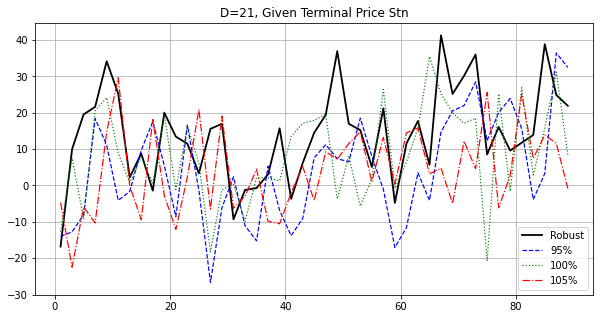

In [21]:
#Merge Outer
plt.figure(figsize = (10,5))
plt.plot(indices, avg_gain[indices],'k-', linewidth = 1.8, label = 'Robust')
plt.plot(indices, avg_gain_h2[indices],'b--', linewidth = 1.2, label = '95%')
plt.plot(indices, avg_gain_h3[indices],'g:', linewidth = 1.2, label = '100%')
plt.plot(indices, avg_gain_h4[indices],'r-.', linewidth = 1.2, label = '105%')
plt.grid(True)
plt.title('D=21, Given Terminal Price Stn')
plt.legend()
plt.show()